In [1]:
import torch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 3.0)

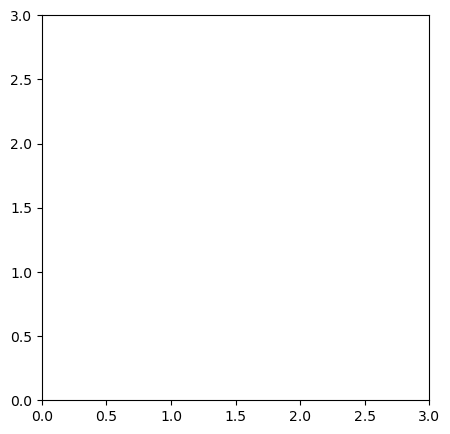

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

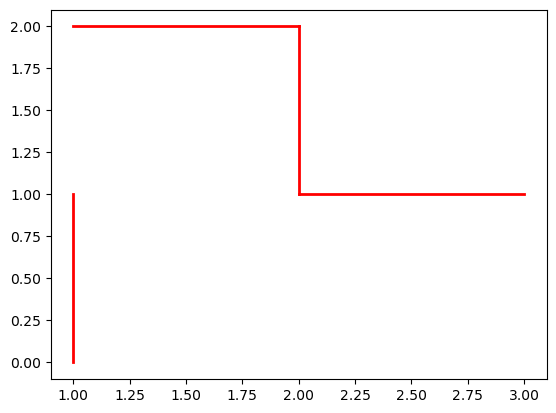

In [4]:
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

In [23]:

ax.text(0.5, 2.5, 'S0', size=14, ha='center')
ax.text(1.5, 2.5, 'S1', size=14, ha='center')
ax.text(2.5, 2.5, 'S2', size=14, ha='center')
ax.text(0.5, 1.5, 'S3', size=14, ha='center')
ax.text(1.5, 1.5, 'S4', size=14, ha='center')
ax.text(2.5, 1.5, 'S5', size=14, ha='center')
ax.text(0.5, 0.5, 'S6', size=14, ha='center')
ax.text(1.5, 0.5, 'S7', size=14, ha='center')
ax.text(2.5, 0.5, 'S8', size=14, ha='center')
ax.text(0.5, 2.3, 'START', ha='center')
ax.text(2.5, 0.3, 'GOAL', ha='center')

Text(2.5, 0.3, 'GOAL')

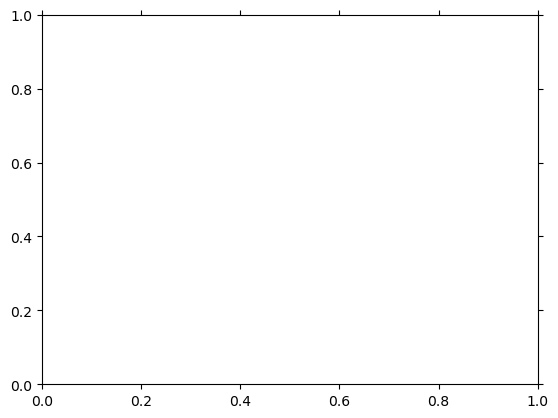

In [25]:

plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

标记S0为起始位置

In [26]:
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

用表格来表达策略$\pi$，其中行表示状态$s$，列表示动作$a$，一共四列，分别表示上右下左四种移动方式，初始状态在S0

其中，np.nan表示不能往某个方向移动，比如在起始位置，不能往左和往上移动。

In [8]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [9]:
torch.cuda.is_available()

True

In [10]:
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan, nan,  1.,  1.],
       [ 1.,  1.,  1., nan],
       [nan, nan,  1.,  1.],
       [ 1., nan, nan, nan],
       [ 1., nan, nan, nan],
       [ 1.,  1., nan, nan]])

In [11]:
theta_0[1, :]

array([nan,  1., nan,  1.])

In [12]:
np.nansum(theta_0[1, :])

2.0

将上述$\theta_0$策略转化为$\pi$函数的定义，（每个状态下执行每个动作的概率）
初始状态下，我们让所有状态平分所有的概率即可

In [13]:
def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    # 对每一行执行操作
    # theta[i, :]表示第i行的所有动作
    for i in range(m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    # 把nan转化为0
    pi = np.nan_to_num(pi)
    return pi

求出初始状态$\pi_0$

In [14]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [15]:
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

依据上一步状态$s$和概率策略$\pi_\theta$，选择移动方向，得到下一步的状态$s_{next}$

In [16]:
def get_next_s(pi, s):
    # 定义方向
    direction = ['u', 'r', 'd', 'l']
    
    # 依据概率随机选择方向
    next_direction = np.random.choice(direction, p = pi[s, :])
    
    # 状态转移
    if next_direction == 'u':
        s_next = s - 3
    elif next_direction == 'r':
        s_next = s + 1
    elif next_direction == 'd':
        s_next = s + 3 
    else:
        s_next = s - 1
    
    return s_next

最暴力的版本，使用死循环求解

In [17]:
def goal_maze(pi):
    s = 0
    state_history = [0]
    
    while 1:
        next_s = get_next_s(pi, s)
        state_history.append(next_s)
        
        if next_s == 8:
            break
        else:
            s = next_s
    return state_history

In [18]:
state_history = goal_maze(pi_0)

In [19]:
state_history

[0, 1, 0, 3, 4, 3, 6, 3, 4, 3, 4, 3, 6, 3, 4, 3, 4, 3, 4, 7, 8]

In [20]:
total_step = len(state_history) - 1

In [21]:
total_step

20

可视化寻路过程

In [22]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([], [])
    return (line, )

def animate(i):
    
    state = state_history[i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8324\2120251764.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
